# Exploration of Chuck Claver's seeing

## Boilerplate

In [13]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple, OrderedDict
from functools import partial
from datetime import datetime, timedelta
import calendar

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

from astropy.coordinates import EarthLocation

## Configuration

In [6]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(6563)

In [3]:
chuck_dir = '/data/des70.a/data/neilsen/obs_strat/data/early_lsst'

## Load full DIMM data

In [12]:
dimm = pd.read_hdf('Pachon_DIMM_to_2019-10-07.h5')
dimm.head()

,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,strehl,r0,log_r0
t,,,,,,,,,,,,,,
2004-03-17 02:33:15+00:00,2004-03-17 02:33:15+00:00,4763,0.71,466228,0.0,0.0,53081.106424,3,2004,3,53081,0.0,0.142352,-0.846637
2004-03-17 02:34:35+00:00,2004-03-17 02:34:35+00:00,4763,0.74,470195,0.0,0.0,53081.107350,3,2004,3,53081,0.0,0.136581,-0.864611
2004-03-17 02:35:42+00:00,2004-03-17 02:35:42+00:00,4763,0.74,460268,0.0,0.0,53081.108125,3,2004,3,53081,0.0,0.136581,-0.864611
2004-03-17 02:36:49+00:00,2004-03-17 02:36:49+00:00,4763,0.75,462758,0.0,0.0,53081.108900,3,2004,3,53081,0.0,0.134760,-0.870440
2004-03-17 02:37:58+00:00,2004-03-17 02:37:58+00:00,4763,0.72,457338,0.0,0.0,53081.109699,3,2004,3,53081,0.0,0.140375,-0.852711


## Load Chuck's files

In [10]:
def read_chucks_dat(fname):
    df = (pd.read_csv(os.path.join(chuck_dir, fname),
                     sep="\s+", header=None, names=('datestr', 'timestr', 'fwhm'),
                     parse_dates={'date':["datestr","timestr"]})
          .set_index('date', drop=False)
          .tz_localize('UTC'))
    return df

chuck = {fn.split('.')[0]: read_chucks_dat(fn) for fn in ('Pachon-dimm-nocut.dat.gz', 'Pachon-dimm-cut.dat.gz')}

fn = 'seeing0201-0402.txt.gz'
chuck[fn.split('.')[0]] = (pd.read_csv(os.path.join(chuck_dir, fn), sep="\t", parse_dates=['date'])
             .set_index('date', drop=False)
             .tz_localize('UTC'))

Supplement the columns there with useful derived columns:

In [17]:
site_longitude_deg = EarthLocation.of_site('Cerro Pachon').lon.deg
site_night_shift = (180.0 + site_longitude_deg)/360.0

for df in chuck.values():
    df.index.name = 't'
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['data_month'] = 12*(df.year - np.min(dimm.year)) + df.month
    df['mjd'] = df.index.to_julian_date() - 2400000.5
    
    df['night'] = np.floor(df.mjd + site_night_shift).astype(int)

In [18]:
for fn in chuck.keys():
    print('***************', fn, '********************')
    print(chuck[fn].describe().T)
    print()

*************** Pachon-dimm-nocut ********************
               count          mean         std           min           25%          50%           75%          max
fwhm        133428.0      0.935160    0.379561      0.020000      0.680000      0.85000      1.080000      4.23000
month       133428.0      7.100346    3.505258      1.000000      4.000000      8.00000     10.000000     12.00000
year        133428.0   2004.698309    0.536033   2004.000000   2004.000000   2005.00000   2005.000000   2006.00000
data_month  133428.0     15.480057    6.274653      5.000000      9.000000     15.00000     22.000000     25.00000
mjd         133428.0  53460.087073  190.949940  53131.949606  53275.140637  53454.00434  53651.112867  53755.36794
night       133428.0  53459.894977  190.951585  53132.000000  53275.000000  53454.00000  53651.000000  53755.00000

*************** Pachon-dimm-cut ********************
              count          mean         std           min           25%           50

## Use values in the DIMM table to fill in Strehl ratio values in Chuck's tables, and check that they are the same measurements

In [27]:
for fn in ['Pachon-dimm-nocut', 'Pachon-dimm-cut']:
    chuck[fn][['strehlL', 'strehlR', 'dimm_fwhm']] = dimm[['strehlL', 'strehlR', 'fwhm']]

In [29]:
for fn in ['Pachon-dimm-nocut', 'Pachon-dimm-cut']:
    df = chuck[fn]
    print((df.fwhm - df.dimm_fwhm).describe())

count    133428.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64
count    87273.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64


## Use plots to find the Strehl ratio cuts applied by Chuck

In [86]:
def plot_density(df, xcol, ycol, ax):
    ax.hist2d(df[xcol], df[ycol], bins=400, norm=mpl.colors.LogNorm(), cmap='viridis_r')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1, 0.1))

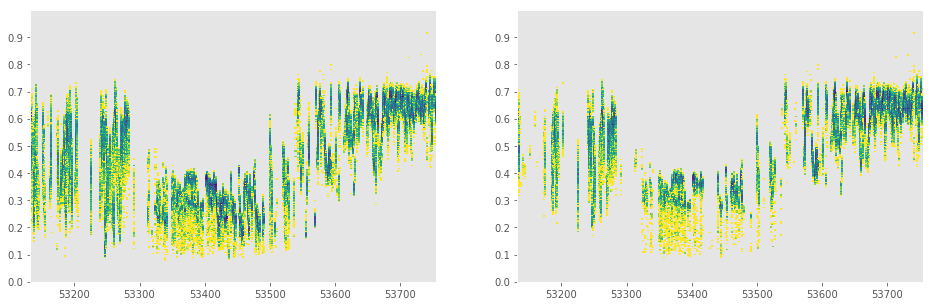

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_density(chuck['Pachon-dimm-nocut'], 'mjd', 'strehlR', axes[0])
plot_density(chuck['Pachon-dimm-cut'], 'mjd', 'strehlR', axes[1])

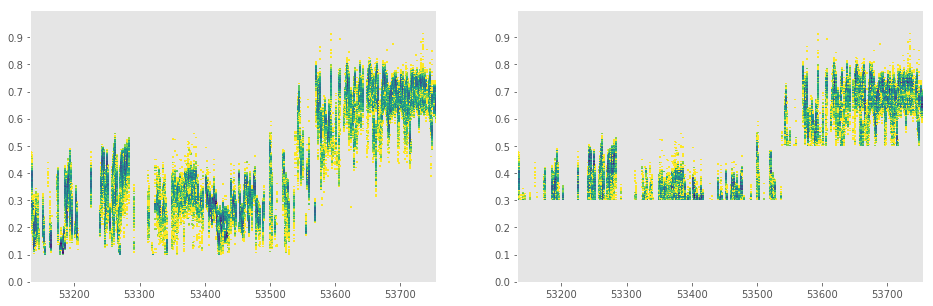

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_density(chuck['Pachon-dimm-nocut'], 'mjd', 'strehlL', axes[0])
plot_density(chuck['Pachon-dimm-cut'], 'mjd', 'strehlL', axes[1])

Okay, it looks like he appled the cut on `strehlL` but not `strehlR`, and had two different cuts depending on date.

Where is the cutoff?

In [58]:
df = chuck['Pachon-dimm-cut']
print("Boundry MJD:", df.loc[df.strehlL<0.5, 'mjd'].max())
print("Boundry Date:", df.loc[df.strehlL<0.5, 'date'].max())

Boundry MJD: 53538.437743055634
Boundry Date: 2005-06-17 10:30:21


Where was the cut?

In [59]:
df = chuck['Pachon-dimm-cut']
print("Early cut:", df.loc[df.mjd < df.loc[df.strehlL<0.5, 'mjd'].max(), 'strehlL'].min())
print("Late cut:", df.loc[df.mjd > df.loc[df.strehlL<0.5, 'mjd'].max(), 'strehlL'].min())

Early cut: 0.301
Late cut: 0.501


Clearly, the cuts are at 0.3 before 2015-06-17, and 0.5 after.

How well correlated are `strehlL` and `strehlR`?

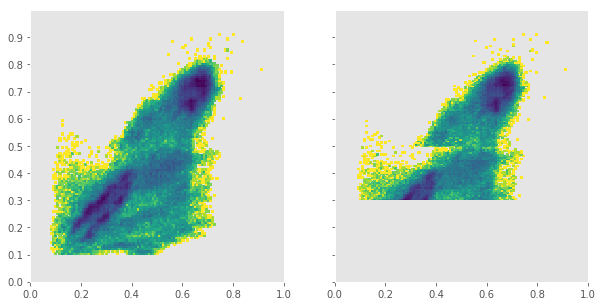

In [69]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
plot_density(chuck['Pachon-dimm-nocut'], 'strehlR', 'strehlL', axes[0])
plot_density(chuck['Pachon-dimm-cut'], 'strehlR', 'strehlL', axes[1])
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

In [93]:
chuck['Pachon-dimm-nocut'].head()

,date,fwhm,month,year,data_month,mjd,night,strehlL,strehlR,dimm_fwhm
t,,,,,,,,,,
2004-05-06 22:47:26+00:00,2004-05-06 22:47:26,1.74,5,2004,5,53131.949606,53132,0.382,0.386,1.74
2004-05-06 22:48:36+00:00,2004-05-06 22:48:36,1.40,5,2004,5,53131.950417,53132,0.400,0.397,1.40
2004-05-06 22:49:46+00:00,2004-05-06 22:49:46,1.40,5,2004,5,53131.951227,53132,0.395,0.405,1.40
2004-05-06 22:50:56+00:00,2004-05-06 22:50:56,1.35,5,2004,5,53131.952037,53132,0.396,0.403,1.35
2004-05-06 22:52:06+00:00,2004-05-06 22:52:06,1.27,5,2004,5,53131.952847,53132,0.384,0.403,1.27


In [97]:
chuck['Pachon-dimm-nocut'].query('mjd>53538')['date'].min()

Timestamp('2005-06-17 00:23:31')